# Sberbank Russian Housing Market


The aim of this competition is to predict the sale price of each property. The target variable is called price_doc in train.csv.
The training data is from August 2011 to June 2015, and the test set is from July 2015 to May 2016. The dataset also includes information about overall conditions in Russia's economy and finance sector, so you can focus on generating accurate price forecasts for individual properties, without needing to second-guess what the business cycle will do.

Data Files
train.csv, test.csv: information about individual transactions. The rows are indexed by the "id" field, which refers to individual transactions (particular properties might appear more than once, in separate transactions). These files also include supplementary information about the local area of each property.
macro.csv: data on Russia's macroeconomy and financial sector (could be joined to the train and test sets on the "timestamp" column)
sample_submission.csv: an example submission file in the correct format
data_dictionary.txt: explanations of the fields available in the other data files
Update: please see the pinned discussion thread for some optional extra data, resolving an issue with some GIS features.

First we would like to investigate the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
from datetime import datetime as dt
#import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [2]:
train_df = pd.read_csv("../input/train.csv")
train_df.shape

(30471, 292)

In [3]:
train_df.head(100)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [4]:
#turn date into date_time 
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = pd.DatetimeIndex(train_df['timestamp']).year
train_df['month'] = pd.DatetimeIndex(train_df['timestamp']).month
train_df['week'] = train_df['timestamp'].dt.week
train_df['day'] = train_df['timestamp'].dt.weekday_name
train_df['yearmonth'] = train_df['timestamp'].dt.to_period('M')

#find what was the month/week/day that had the most sales, highest sales prices

price_date = train_df[['timestamp','year','month','week','day','price_doc']]
print 'Best sales date is:' '{}' ' sales amount:' '{}'.format(price_date.groupby('timestamp')['price_doc'].sum().argmax(),price_date.groupby('timestamp')['price_doc'].sum().max())
print 'Best sales month is:' '{}' ' sales number:' '{}'.format(price_date.groupby('month')['price_doc'].sum().argmax(),price_date.groupby('month')['price_doc'].count().max())
print 'Best sales week is:' '{}' ' sales number:' '{}'.format(price_date.groupby('week')['price_doc'].sum().argmax(),price_date.groupby('week')['price_doc'].count().max())
print 'Best sales day is:' '{}' ' sales number:' '{}'.format(price_date.groupby('day')['price_doc'].sum().argmax(),price_date.groupby('day')['price_doc'].count().max())

#price_date.groupby('month')['price_doc'].max().head(12)

Best sales date is:2014-12-16 00:00:00 sales amount:1277010582
Best sales month is:12 sales number:3400
Best sales week is:51 sales number:1009
Best sales day is:Tuesday sales number:6091


C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  if sys.path[0] == '':
C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  del sys.path[0]
C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the

Train set with time dimension

In [5]:
train_df.head()


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [6]:
#calculate the price per one life_sq
train_df['one_life_sq_price']=train_df['price_doc']/train_df['life_sq']
train_df[['price_doc','life_sq','one_life_sq_price']].head()

,price_doc,life_sq,one_life_sq_price
0,5850000,27.0,216666.666667
1,6000000,19.0,315789.473684
2,5700000,29.0,196551.724138
3,13100000,50.0,262000.000000
4,16331452,77.0,212096.779221


In [7]:
#sub_area that have the highest prices per sub_area
sub_area_df = train_df[['id','price_doc','sub_area']].head()

'Highest Prices Sub area is:' '{}' ' worth of:' '{}'.format(sub_area_df.groupby('sub_area')['price_doc'].sum().argmax(),sub_area_df.groupby('sub_area')['price_doc'].sum().max())

C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


'Highest Prices Sub area is:Basmannoe worth of:16331452'

In [8]:
#for each sub area what are the top 3 columns with the largest number of nuls (df.isnull().sum())
#train_df.isnull().sum().head(100)
sub_df = train_df.groupby('sub_area').apply(lambda x: x.isnull().sum()).T
print(sub_df.shape)
sub_df.head(5)

(298, 146)


sub_area,Ajeroport,Akademicheskoe,Alekseevskoe,Altuf'evskoe,Arbat,Babushkinskoe,Basmannoe,Begovoe,Beskudnikovskoe,Bibirevo,Birjulevo Vostochnoe,Birjulevo Zapadnoe,Bogorodskoe,Brateevo,Butyrskoe,Caricyno,Cheremushki,Chertanovo Central'noe,Chertanovo Juzhnoe,Chertanovo Severnoe,Danilovskoe,Dmitrovskoe,Donskoe,Dorogomilovo,Filevskij Park,Fili Davydkovo,Gagarinskoe,Gol'janovo,Golovinskoe,Hamovniki,Horoshevo-Mnevniki,Horoshevskoe,Hovrino,Ivanovskoe,Izmajlovo,Jakimanka,Jaroslavskoe,Jasenevo,Juzhnoe Butovo,Juzhnoe Medvedkovo,Juzhnoe Tushino,Juzhnoportovoe,Kapotnja,Kon'kovo,Koptevo,Kosino-Uhtomskoe,Kotlovka,Krasnosel'skoe,Krjukovo,Krylatskoe,Kuncevo,Kurkino,Kuz'minki,Lefortovo,Levoberezhnoe,Lianozovo,Ljublino,Lomonosovskoe,Losinoostrovskoe,Mar'ina Roshha,Mar'ino,Marfino,Matushkino,Meshhanskoe,Metrogorodok,Mitino,Molzhaninovskoe,Moskvorech'e-Saburovo,Mozhajskoe,Nagatino-Sadovniki,Nagatinskij Zaton,Nagornoe,Nekrasovka,Nizhegorodskoe,Novo-Peredelkino,Novogireevo,Novokosino,Obruchevskoe,Ochakovo-Matveevskoe,Orehovo-Borisovo Juzhnoe,Orehovo-Borisovo Severnoe,Ostankinskoe,Otradnoe,Pechatniki,Perovo,Pokrovskoe Streshnevo,Poselenie Desjonovskoe,Poselenie Filimonkovskoe,Poselenie Kievskij,Poselenie Klenovskoe,Poselenie Kokoshkino,Poselenie Krasnopahorskoe,Poselenie Marushkinskoe,Poselenie Mihajlovo-Jarcevskoe,Poselenie Moskovskij,Poselenie Mosrentgen,Poselenie Novofedorovskoe,Poselenie Pervomajskoe,Poselenie Rjazanovskoe,Poselenie Rogovskoe,Poselenie Shhapovskoe,Poselenie Shherbinka,Poselenie Sosenskoe,Poselenie Vnukovskoe,Poselenie Voronovskoe,Poselenie Voskresenskoe,Preobrazhenskoe,Presnenskoe,Prospekt Vernadskogo,Ramenki,Rjazanskij,Rostokino,Savelki,Savelovskoe,Severnoe,Severnoe Butovo,Severnoe Izmajlovo,Severnoe Medvedkovo,Severnoe Tushino,Shhukino,Silino,Sokol,Sokol'niki,Sokolinaja Gora,Solncevo,Staroe Krjukovo,Strogino,Sviblovo,Taganskoe,Tekstil'shhiki,Teplyj Stan,Timirjazevskoe,Troickij okrug,Troparevo-Nikulino,Tverskoe,Veshnjaki,Vnukovo,Vojkovskoe,Vostochnoe,Vostochnoe Degunino,Vostochnoe Izmajlovo,Vyhino-Zhulebino,Zamoskvorech'e,Zapadnoe Degunino,Zjablikovo,Zjuzino
id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
timestamp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
full_sq,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
life_sq,1,0,4,0,0,2,0,0,0,1,2,0,4,0,0,0,0,14,44,19,19,0,15,0,4,0,3,0,0,4,6,34,3,0,36,5,0,6,8,0,2,1,9,0,0,0,1,0,125,2,0,0,0,2,11,0,0,6,10,11,1,0,0,3,0,215,0,0,0,5,60,72,1024,1,7,0,0,39,17,2,17,1,1,0,0,32,166,250,1,0,7,2,0,0,578,4,75,67,6,24,0,223,1147,877,1,145,0,3,6,31,0,2,0,0,3,3,0,0,41,0,0,0,0,0,116,0,47,16,0,83,2,1,19,1,346,3,0,1,0,0,0,0,3,172,0,0
floor,0,0,0,0,0,3,0,0,4,0,3,1,0,0,1,2,0,0,2,2,0,0,0,1,1,0,0,0,4,0,0,0,0,0,3,0,0,1,2,1,2,0,0,0,3,0,0,0,0,0,0,1,0,1,2,0,1,1,0,1,2,1,0,2,0,0,0,0,1,1,2,1,2,1,0,1,0,3,1,1,1,0,1,0,1,0,2,0,0,0,0,0,0,0,2,0,0,11,1,0,0,3,3,3,1,27,0,1,1,0,0,0,0,2,0,2,1,0,1,1,0,0,0,0,2,0,1,0,0,0,1,0,25,0,4,0,0,1,0,0,0,1,1,1,1,2


Figure top missing features

In [9]:
sum_na = sub_df.apply(lambda x: sum(x) , axis=1)


print 'large NA features:' 
print sum_na.nlargest(10)
print " "
print 'Small NA features:'
print sum_na.loc[lambda x : x!=0].nsmallest(10)
 



        


large NA features:
hospital_beds_raion           14441
build_year                    13605
state                         13559
cafe_sum_500_min_price_avg    13281
cafe_sum_500_max_price_avg    13281
cafe_avg_price_500            13281
max_floor                      9572
material                       9572
num_room                       9572
kitch_sq                       9572
dtype: int64
 
Small NA features:
metro_min_walk                  25
metro_km_walk                   25
railroad_station_walk_km        25
railroad_station_walk_min       25
ID_railroad_station_walk        25
floor                          167
prom_part_5000                 178
cafe_sum_5000_min_price_avg    297
cafe_sum_5000_max_price_avg    297
cafe_avg_price_5000            297
dtype: int64


Common missing feature among suberbs   

Common NA fetures among sub areas:[('hospital_beds_raion', 41), ('state', 57), ('cafe_sum_500_min_price_avg', 22), ('preschool_quota', 21), ('build_year', 5)]


C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.
C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


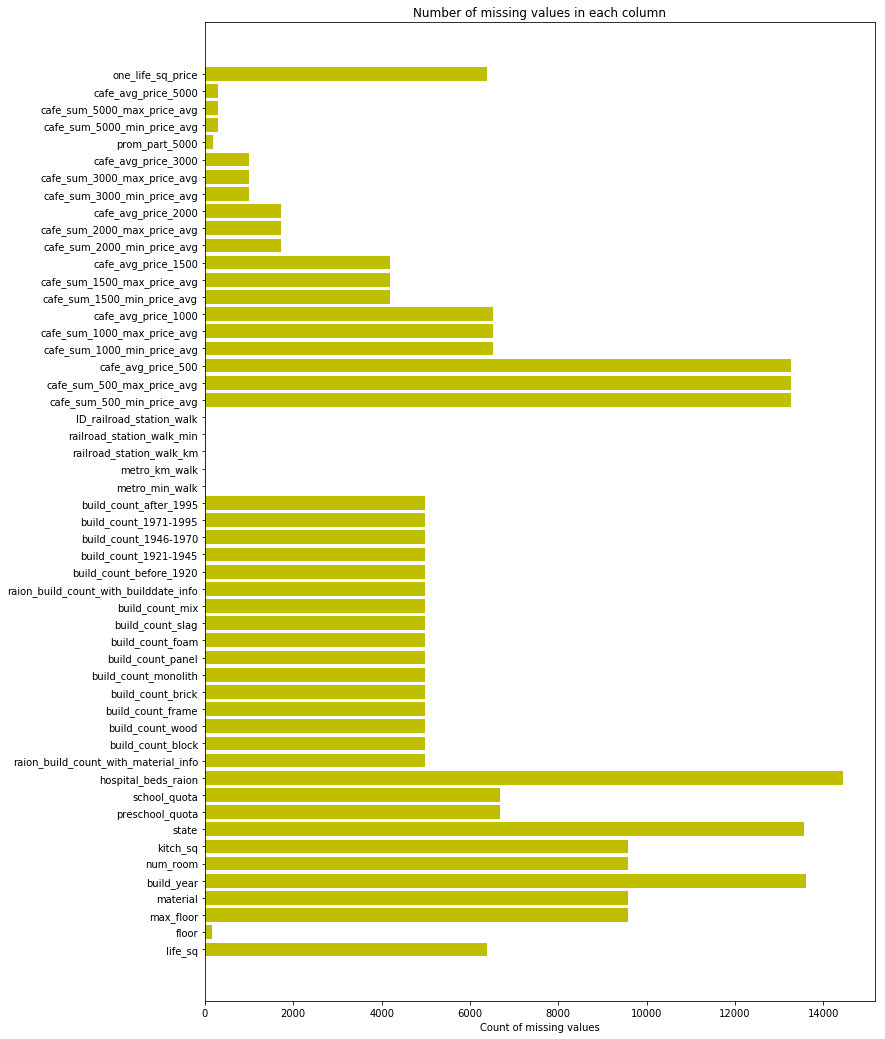

In [10]:

dict_sub={}
for ch in sub_df:
    dict_sub[ch] = sub_df[ch].argmax()

#calc common NA features
dict_v={}
for v in dict_sub.values():
    dict_v[v]=dict_sub.values().count(v)
  
print 'Common NA fetures among sub areas:' '{}'.format(dict_v.items())

#print 'Sub area common NA features: ' '{}'.format(dict_sub.items())

missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [11]:
#choose a sub area and for each of the 3 columns with the most number of nuls: Find a value to fill these nuls,explain why you chose the value 
for ch in sub_df:
    print ch
    print(sub_df[ch].nlargest(3))
    

    

Ajeroport
state         51
build_year    48
max_floor     47
Name: Ajeroport, dtype: int64
Akademicheskoe
state         75
build_year    60
max_floor     56
Name: Akademicheskoe, dtype: int64
Alekseevskoe
state         37
build_year    35
max_floor     33
Name: Alekseevskoe, dtype: int64
Altuf'evskoe
hospital_beds_raion    68
state                  33
max_floor              23
Name: Altuf'evskoe, dtype: int64
Arbat
state        9
max_floor    7
material     7
Name: Arbat, dtype: int64
Babushkinskoe
state         61
build_year    57
max_floor     56
Name: Babushkinskoe, dtype: int64
Basmannoe
state         40
build_year    35
max_floor     34
Name: Basmannoe, dtype: int64
Begovoe
state         23
build_year    21
max_floor     19
Name: Begovoe, dtype: int64
Beskudnikovskoe
state         59
build_year    53
max_floor     52
Name: Beskudnikovskoe, dtype: int64
Bibirevo
state         99
build_year    65
max_floor     63
Name: Bibirevo, dtype: int64
Birjulevo Vostochnoe
cafe_sum_500_min_pri

In [12]:
print 'num of rows for Ivanovskoe:' '{}'.format(train_df[train_df['sub_area']=='Ivanovskoe'].count().max())
print sub_df['Ivanovskoe'].nlargest(3)

num of rows for Ivanovskoe:197
hospital_beds_raion           197
cafe_sum_500_min_price_avg    117
cafe_sum_500_max_price_avg    117
Name: Ivanovskoe, dtype: int64


we realize that overall Ivanovskoe recordes = 197 . Ivanovskoe dont have any hospital_bed_raion, in general all our data records=30471 we found that the most common NA's fetures is hospital_beds_raion = 14441 (almost 50% of our data records dont have this feature). there for my deccision was to remove the column.

In [13]:
print train_df.shape
del train_df['hospital_beds_raion']
print train_df.shape

(30471, 298)
(30471, 297)


Now I would look for the new top 3 NA features

In [14]:
print 'num of rows for Ivanovskoe:' '{}'.format(train_df[train_df['sub_area']=='Ivanovskoe'].count().max())
sub_df = train_df.groupby('sub_area').apply(lambda x: x.isnull().sum()).T
print sub_df['Ivanovskoe'].nlargest(3)

num of rows for Ivanovskoe:197
cafe_sum_500_min_price_avg    117
cafe_sum_500_max_price_avg    117
cafe_avg_price_500            117
Name: Ivanovskoe, dtype: int64


Those features are missing data equaly=117 records , I decided to look for mean() value per feature and to fill the NAN values in order to obtain the statistics.

In [15]:
df2 = train_df[train_df['sub_area']=='Ivanovskoe']
df2[['cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500']].mean()

cafe_sum_500_min_price_avg    477.9375
cafe_sum_500_max_price_avg    904.6875
cafe_avg_price_500            691.3125
dtype: float64

In [16]:
train_df['cafe_avg_price_500'][train_df['sub_area']=='Ivanovskoe'] = train_df['cafe_avg_price_500'][train_df['sub_area']=='Ivanovskoe'].replace(np.nan,691)
train_df['cafe_sum_500_max_price_avg'][train_df['sub_area']=='Ivanovskoe'] = train_df['cafe_sum_500_max_price_avg'][train_df['sub_area']=='Ivanovskoe'].replace(np.nan,904)
train_df['cafe_sum_500_min_price_avg'][train_df['sub_area']=='Ivanovskoe'] = train_df['cafe_sum_500_min_price_avg'][train_df['sub_area']=='Ivanovskoe'].replace(np.nan,477)


train_df[['cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500']][train_df['sub_area']=='Ivanovskoe']

,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500
128,477.00,904.00,691.00
131,477.00,904.00,691.00
188,500.00,1000.00,750.00
244,477.00,904.00,691.00
281,500.00,1000.00,750.00
329,477.00,904.00,691.00
373,477.00,904.00,691.00
402,477.00,904.00,691.00
429,477.00,904.00,691.00
484,477.00,904.00,691.00


Investigate for new top 3 NAN's .

In [17]:
sub_df = train_df.groupby('sub_area').apply(lambda x: x.isnull().sum()).T
print sub_df['Ivanovskoe'].nlargest(3)

state         53
build_year    52
max_floor     51
Name: Ivanovskoe, dtype: int64


well...I can live with that

C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


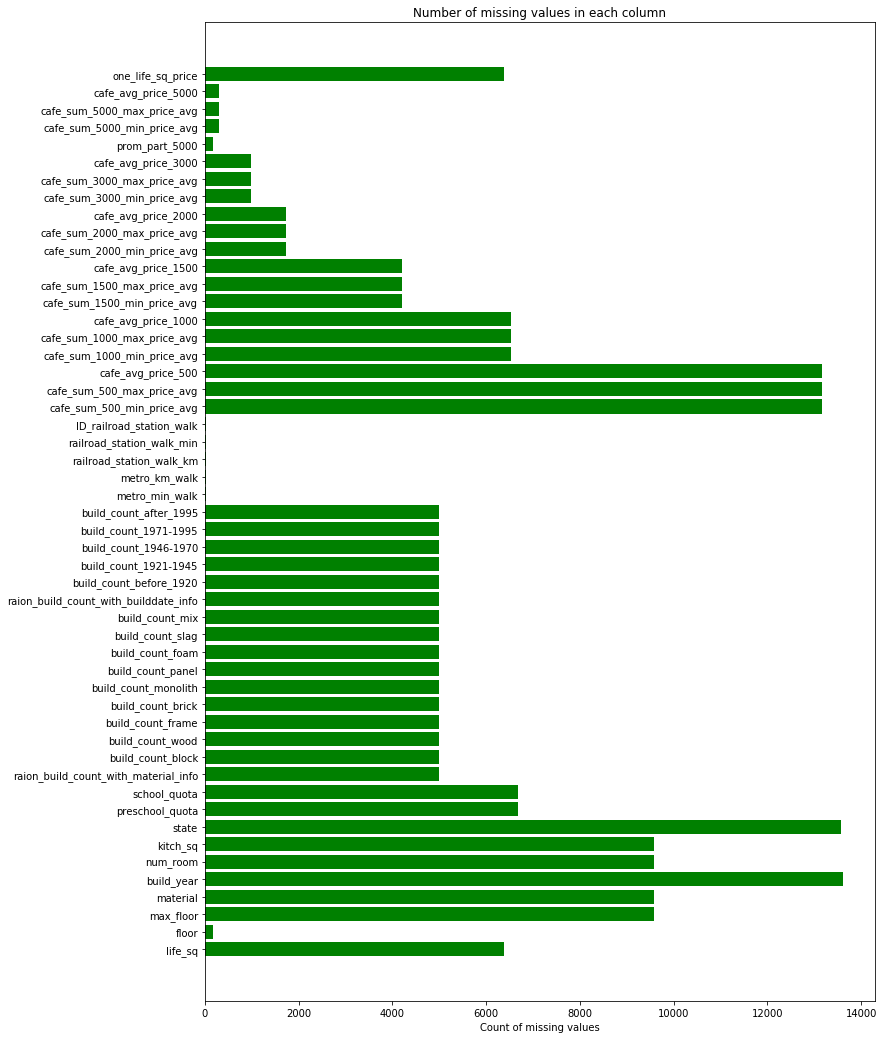

In [18]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='g')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

# EDA

There are quite a few variables in this dataset.
Let us start with target variable exploration - 'price_doc'

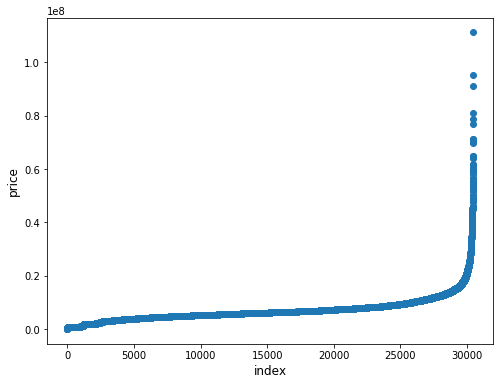

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

we should bin the price

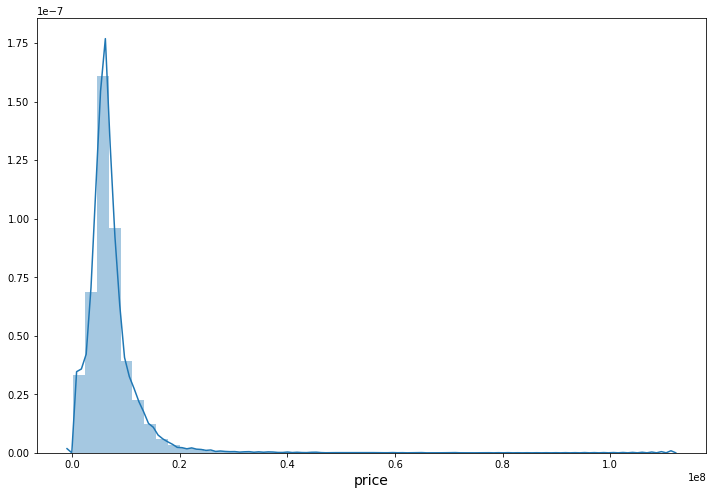

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=14)
plt.show()

Since our metric is Root Mean Square Logarithmic error, let us plot the log of price_doc variable.

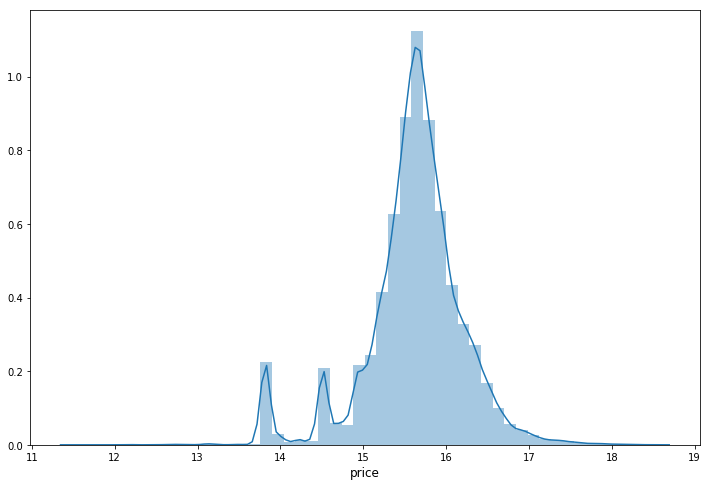

In [21]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()


lets investigate the price median changes over time

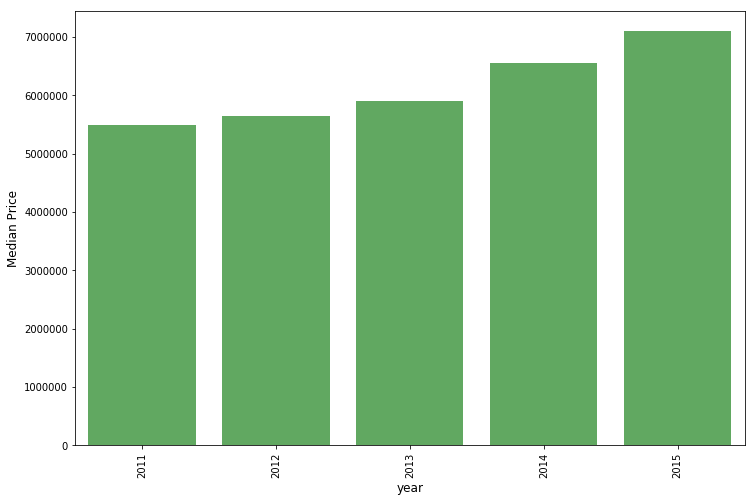

In [22]:
grouped_df = train_df.groupby('year')['price_doc'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['year'].values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('year', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

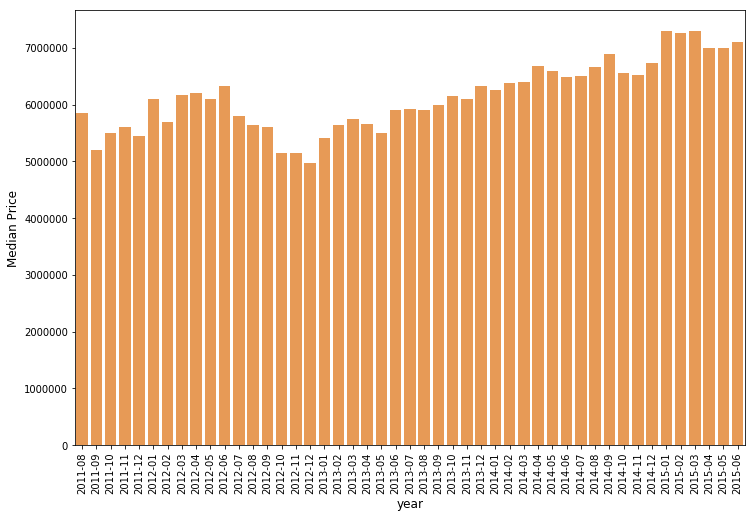

In [23]:
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['yearmonth'].values, grouped_df.price_doc.values, alpha=0.8, color=color[1])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('year', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

lets invastigae the variables 

C:\Users\noak.EDEN-TELECOM\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


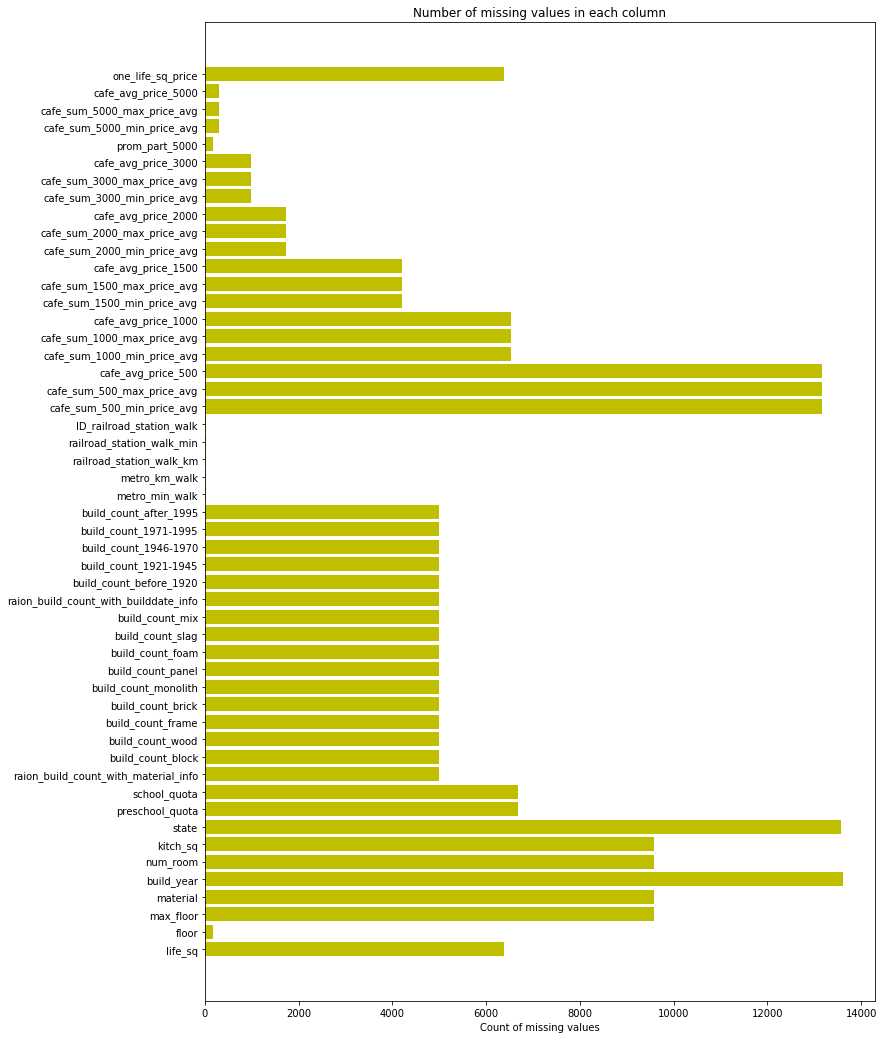

In [24]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [25]:

for c in train_df:
    if train_df[c].dtype <> 'int64':
        train_df=train_df.drop(c,axis=1)


In [26]:
train_df.head()

,id,full_sq,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,ID_metro,ID_railroad_station_avto,ID_big_road1,ID_big_road2,ID_railroad_terminal,ID_bus_terminal,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,week
0,1,43,155572,9576,5,10309,5,0,1,0,7,3,0,16,1,86206,40477,45729,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,17508,9425,8083,18654,9709,8945,1,1,1,5,101,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,30500,3,55600,19,1,10,4,3,1,0,0,1,2,0,0,6,1,3,39554,9,171420,34,1,14,11,6,2,0,0,1,2,0,0,7,1,9,188854,19,1244891,36,1,15,11,6,2,1,0,1,2,0,0,10,1,12,251554,23,1419204,68,5,21,22,16,3,1,0,2,4,0,0,21,1,29,807385,52,4036616,152,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000,2011,8,33
1,2,34,115352,6880,5,7759,8,0,1,0,6,1,1,3,0,76284,34200,42084,15727,7925,7802,70194,35622,34572,29431,9266,20165,6880,3466,3414,7759,3909,3850,17700,8998,8702,15164,7571,7593,13729,6929,6800,2,2,2,4,32,2,0,0,0,0,5,0,1,3,0,0,1,0,0,1,0,0,0,0,2,86600,5,94065,13,0,5,6,1,0,1,0,1,2,0,4,2,0,3,102910,7,127065,17,0,6,7,1,2,1,0,1,5,0,4,9,0,4,165510,8,179065,21,0,7,8,3,2,1,0,1,5,0,4,11,0,12,821986,14,491565,30,1,11,11,4,2,1,0,1,7,0,6,19,1,66,2690465,40,2034942,177,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000,2011,8,34
2

In [59]:
from sklearn.model_selection import train_test_split

x=train_df.drop("price_doc", axis=1)
y=train_df["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
 x, y,random_state=1)


In [60]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.9780772765063668
0.047387765817799944


In [62]:
#df_test = pd.read_csv("../input/test.csv")
results = clf.predict(X = X_test)
